# Module 8 Project: The Spatial Correlation between Housing Costs and “Perfect” Weather (Air Temperatures) within Coastal Regions of Southern California

#### Set up environment and import libraries

In [1]:
# install necessary packages for GHCN data processing
!pip install metpy
!pip install cartopy
!pip install goes2go
!git clone https://github.com/scotthosking/get-station-data.git
!ls
%cd get-station-data/
!pip install -v -e .
%cd ..

fatal: destination path 'get-station-data' already exists and is not an empty directory.
get-station-data  sample_data
/content/get-station-data
Using pip 24.1.2 from /usr/local/lib/python3.12/dist-packages/pip (python 3.12)
Obtaining file:///content/get-station-data
  Running command python setup.py egg_info
  running egg_info
  creating /tmp/pip-pip-egg-info-9_w6br06/get_station_data.egg-info
  writing /tmp/pip-pip-egg-info-9_w6br06/get_station_data.egg-info/PKG-INFO
  writing dependency_links to /tmp/pip-pip-egg-info-9_w6br06/get_station_data.egg-info/dependency_links.txt
  writing requirements to /tmp/pip-pip-egg-info-9_w6br06/get_station_data.egg-info/requires.txt
  writing top-level names to /tmp/pip-pip-egg-info-9_w6br06/get_station_data.egg-info/top_level.txt
  writing manifest file '/tmp/pip-pip-egg-info-9_w6br06/get_station_data.egg-info/SOURCES.txt'
  reading manifest file '/tmp/pip-pip-egg-info-9_w6br06/get_station_data.egg-info/SOURCES.txt'
  adding license file 'LICENSE'


In [2]:
# access data from Google Drive directory
from google.colab import drive
drive.mount('/content/drive')
dir = '/content/drive/My Drive/'

# import Python libs
import cartopy.crs as ccrs         # map projections
import cartopy.feature as cfeature # map features
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import xarray as xr
import glob, os
from metpy.interpolate import interpolate_to_grid
from matplotlib.colors import BoundaryNorm
from scipy.stats import spearmanr
import matplotlib
# add Latex to matplotlib figures
plt.rcParams['text.usetex'] = False
# update standard matplotlib fig font size
matplotlib.rcParams.update({'font.size': 14})

# Celsius to Fahr conversion
def CtoF(celsius):
    return (celsius * 9/5) + 32

Mounted at /content/drive


## Data Uploading and Processing

##### Zillow housing price and neighborhood/city polygon datasets

In [3]:
# import Zillow housing prices data by neighborhood/city
# Source: https://www.zillow.com/research/data/
zillow = pd.read_csv(dir + \
  'Neighborhood_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')
# preview San Diego data
zillow[zillow['City'] == 'San Diego'].head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,2025-09-30,2025-10-31
90,116625,90,Mira Mesa,neighborhood,CA,CA,San Diego,"San Diego-Chula Vista-Carlsbad, CA",San Diego County,191416.089151,...,1.039073e+06,1.037145e+06,1.033259e+06,1.026706e+06,1.017029e+06,1.006201e+06,9.979971e+05,9.923184e+05,9.892974e+05,9.886401e+05
182,117557,187,Rancho Penasquitos,neighborhood,CA,CA,San Diego,"San Diego-Chula Vista-Carlsbad, CA",San Diego County,271126.145538,...,1.421131e+06,1.421003e+06,1.418756e+06,1.411852e+06,1.398213e+06,1.379820e+06,1.362104e+06,1.346695e+06,1.337279e+06,1.334219e+06
198,273140,204,Carmel Valley,neighborhood,CA,CA,San Diego,"San Diego-Chula Vista-Carlsbad, CA",San Diego County,366382.134223,...,1.912922e+06,1.922616e+06,1.929222e+06,1.932028e+06,1.923279e+06,1.906092e+06,1.887525e+06,1.875190e+06,1.871520e+06,1.874691e+06
201,118673,207,University City,neighborhood,CA,CA,San Diego,"San Diego-Chula Vista-Carlsbad, CA",San Diego County,239295.197946,...,1.031472e+06,1.032541e+06,1.031954e+06,1.029312e+06,1.021563e+06,1.012229e+06,1.003587e+06,9.975299e+05,9.932426e+05,9.904795e+05
244,275127,253,Rancho Bernardo,neighborhood,CA,CA,San Diego,"San Diego-Chula Vista-Carlsbad, CA",San Diego County,227026.346283,...,1.026712e+06,1.028332e+06,1.026332e+06,1.020554e+06,1.012038e+06,1.002171e+06,9.923332e+05,9.838859e+05,9.781136e+05,9.749681e+05


In [4]:
# import 2008 Zillow geopandas df w/ neighborhood polygons
# Source: https://github.com/stepps00/zillow-neighborhoods
neigh_df = gpd.read_file(dir + 'ZillowNeighborhoods-CA.shp')

# import California city boundary polygons (for SoCal counties) as geopandas df
# Source: https://data.ca.gov/dataset/california-city-boundaries-and-identifiers
ca_city = gpd.read_file(dir + 'California_City_Boundaries_and_Identifiers.shp')
ca_city = ca_city[ca_city['CDTFA_COUN'].isin(['San Bernardino County',
                                    'Los Angeles County', 'Riverside County', 'Orange County', 'San Diego County'])]
ca_city.head()

,CDTFA_COPR,CDTFA_CITY,CDTFA_COUN,CENSUS_PLA,CENSUS_GEO,CENSUS_P_1,GNIS_PLACE,GNIS_ID,CDT_CITY_A,CDT_COUNTY,PRIMARY_DO,CENSUS_POP,CDT_NAME_S,OFFSHORE,AREA_SQMI,GlobalID,geometry
0,36014,Adelanto,San Bernardino County,Adelanto,0600296,City,City of Adelanto,2409663,ADEL,SBD,None,0,Adelanto,None,52.882650,749cd1c9-3f7a-401e-a4f1-617fd2c52375,"MULTIPOLYGON (((241939.832 -371206.919, 241780..."
1,19205,Agoura Hills,Los Angeles County,Agoura Hills,0600394,City,City of Agoura Hills,2409666,AGRH,LAC,None,0,Agoura Hills,None,7.818240,a255e6b6-e979-4461-9865-484410b2e2d5,"POLYGON ((118062.449 -430252.243, 118062.451 -..."
4,19206,Alhambra,Los Angeles County,Alhambra,0600884,City,City of Alhambra,2409681,ALHB,LAC,None,0,Alhambra,None,7.632097,d6d6ba34-88f9-4935-a053-c8a671cbdf00,"POLYGON ((173339.516 -432761.043, 173388.249 -..."
5,30034,Aliso Viejo,Orange County,Aliso Viejo,0600947,City,City of Aliso Viejo,2409683,ASVJ,ORA,None,0,Aliso Viejo,None,6.919420,f6b37bc2-26b0-4ffc-9d1d-18ef199d0dea,"POLYGON ((212022.629 -488236.554, 212015.998 -..."
9,30001,Anaheim,Orange County,Anaheim,0602000,City,City of Anaheim,2409704,ANAH,ORA,None,0,Anaheim,None,50.925300,9a9de2d8-2c24-45fd-8743-bc0e61785839,"POLYGON ((214298.749 -457860.239, 214303.562 -..."


##### Joining Zillow neighborhood and CA city geopandas dataframes

In [5]:
# projections used for GIS analysis
to_proj = ccrs.AlbersEqualArea(central_longitude=-117.5, central_latitude=33.5)

# append LA & SD neighborhoods with southern CA city polygons
socal_cities = ca_city[~ca_city['CDTFA_CITY'].isin(
    ['Los Angeles','San Diego'])]
socal_cities = socal_cities[['CDTFA_COUN', 'CDTFA_CITY',
                             'GNIS_PLACE', 'geometry']]
socal_cities.columns = ['COUNTY', 'CITY', 'NAME', 'geometry']
la_sd_neigh = neigh_df[neigh_df['CITY'].isin(['Los Angeles','San Diego'])]
la_sd_neigh = la_sd_neigh[['COUNTY', 'CITY', 'NAME', 'geometry']]
# maintain same CRS for both geopandas dfs
la_sd_neigh = la_sd_neigh.to_crs(socal_cities.crs)

# create final geopandas df for all neighborhood/city boundaries to crop
# weather datasets and Zillow housing prices
polys_neigh = pd.concat([la_sd_neigh, socal_cities])
# reproject neigh/city polygons to AlbersEqual CRS for overlay analysis w/
# temperature extrema GCHN data
polys_neigh = polys_neigh.to_crs(to_proj)
polys_neigh = polys_neigh.reset_index()
# preview geopandas df
polys_neigh.head()

,index,COUNTY,CITY,NAME,geometry
0,295,Los Angeles,Los Angeles,Arleta,"POLYGON ((-80420.84 86166.712, -81576.054 8509..."
1,296,Los Angeles,Los Angeles,Atwater Village,"POLYGON ((-69443.937 75178.013, -69262.271 752..."
2,297,Los Angeles,Los Angeles,Bel Air,"POLYGON ((-87262.496 71797.305, -87144.305 717..."
3,298,Los Angeles,Los Angeles,Beverly Glen,"MULTIPOLYGON (((-84360.169 72183.073, -84311.7..."
4,299,Los Angeles,Los Angeles,Boyle Heights,"POLYGON ((-64647.186 63609.528, -64494.645 637..."


##### Daily Temperature Extrema from GCHN weather station dataset

In [ ]:
'''
DATA PROCESSING FOR GCHN STATION TEMPERATURE EXTREMA IN SOUTHERN CA
'''
# import custom GCHN python lib functions
from get_station_data import ghcnd
from get_station_data.util import nearest_stn

# get station metadata
stn_md = ghcnd.get_stn_metadata()

# extract relevant 2025 operating stations in SoCal
sd_stns = nearest_stn(stn_md, -117.5, 32.9,
                      n_neighbours=500).query(
                          'end_year == 2025'
                      )
la_stns = nearest_stn(stn_md, -118.15, 33.6,
                      n_neighbours=800).query(
                          'end_year == 2025'
                      )
stns = pd.concat([la_stns, sd_stns]).drop_duplicates().reset_index(drop=True)

# download and save station weather data into csv file
df = ghcnd.get_data(stns)
df.to_csv(dir + 'socal_temps_GHCN.csv', index=False)

In [6]:
# get daily GCHN weather station data and convert dates to usable format
df = pd.read_csv(dir + 'socal_temps_GHCN.csv')
df['date'] = pd.to_datetime(df['date'])

# subset desired time range and station min & max temps (TMIN & TMAX)
temps = df[df['element'].isin(['TMIN', 'TMAX']) & (df['date'].dt.year == 2024)\
           & df['date'].dt.month.isin([6, 7, 8])]

# suppress annoying pandas notices
import warnings
import warnings; warnings.filterwarnings("ignore")
# get day number (of year) for every date for easier indexing
temps['day_num'] = 0.0
for i in range(len(temps.date)):
    temps.day_num.iloc[i] = temps.date.iloc[i].timetuple().tm_yday

##### Interpolate GCHN data to a 2 km grid and calculate neighborhood and city-scale TMIN and TMAX

In [17]:
# get daily mean TMIN & TMAX for all neigh/city polygons from Jun-Aug 2024
# using day number as index
for idx in np.arange(153, 244+1):
    # index tracker
    print(idx)

    # create column names for mean TMIN & TMAX of each neigh/city polygon
    polys = polys_neigh.copy()
    polys['TMIN_mean' + str(idx)] = np.nan
    polys['TMAX_mean' + str(idx)] = np.nan

    # get TMIN/TMAX records to create daily interpolated 2 km res grid
    temps_daily = temps[temps['day_num'] == idx]
    max_temps_daily = temps_daily[temps_daily['element'] == 'TMAX']
    max_temps_daily = max_temps_daily.dropna(subset=['value'])
    max_temps_daily = max_temps_daily[max_temps_daily['value'] >= 0]
    min_temps_daily = temps_daily[temps_daily['element'] == 'TMIN']
    min_temps_daily = min_temps_daily.dropna(subset=['value'])
    min_temps_daily = min_temps_daily[min_temps_daily['value'] >= 0]

    ############# TMAX #############
    # reproject points to create interpolated 2 km grid with metpy
    from_proj = ccrs.Geodetic()
    if from_proj is not None and to_proj is not None:
        proj_points = to_proj.transform_points(from_proj,
                                               max_temps_daily.lon,
                                               max_temps_daily.lat)
    long, lati = proj_points[:, 0], proj_points[:, 1]
    # convert interpolated TMAX/TMIN grids into xarray Datasets
    gx, gy, img = interpolate_to_grid(long,
                                      lati,
                                      max_temps_daily.value,
                                      interp_type='natural_neighbor',
                                      hres=2000) # meters
    maxtemps_xr = xr.Dataset({
                'temperature': (['y', 'x'], img),
            },
            coords={
                'latitude': (['y', 'x'], gy),
                'longitude': (['y', 'x'], gx),
            }
        )
    ############# TMIN #############
    # reproject points to create interpolated 2 km grid with metpy
    from_proj = ccrs.Geodetic()
    to_proj = ccrs.AlbersEqualArea(central_longitude=-117.5,
                                   central_latitude=33.5)
    #to_proj = ccrs.PlateCarree(central_longitude=-117.5)
    if from_proj is not None and to_proj is not None:
        proj_points = to_proj.transform_points(from_proj,
                                               min_temps_daily.lon,
                                               min_temps_daily.lat)
    long, lati = proj_points[:, 0], proj_points[:, 1]
    # convert interpolated TMIN grids into xarray Datasets
    gx, gy, img = interpolate_to_grid(long,
                                      lati,
                                      min_temps_daily.value,
                                      interp_type='natural_neighbor',
                                      hres=2000)
    mintemps_xr = xr.Dataset({
                'temperature': (['y', 'x'], img),
            },
            coords={
                'latitude': (['y', 'x'], gy),
                'longitude': (['y', 'x'], gx),
            }
        )

    # convert interpolated grids back to shapely points for easier data
    # extraction with neighborhood/city polygons
    mint = mintemps_xr.to_dataframe()
    mint = mint.reset_index()
    mint_gdf = gpd.GeoDataFrame(mint, geometry=gpd.points_from_xy(
        mint.longitude, mint.latitude), crs=to_proj.proj4_init)#"EPSG:3310")
    maxt = maxtemps_xr.to_dataframe()
    maxt = maxt.reset_index()
    maxt_gdf = gpd.GeoDataFrame(maxt, geometry=gpd.points_from_xy(
        maxt.longitude, maxt.latitude), crs=to_proj.proj4_init)#"EPSG:3310")

    # append daily mean TMIN/TMAX for each neigh/city boundary to polys df
    for row in range(polys.shape[0]):
        # subset grid pts within each neighborhood/city polygon
        pip_min = mint_gdf.within(polys.loc[row, 'geometry'])
        pts_in_poly_min = mint_gdf.loc[pip_min]
        pip_max = maxt_gdf.within(polys.loc[row, 'geometry'])
        pts_in_poly_max = maxt_gdf.loc[pip_max]
        # calculate daily mean of TMIN/TMAX
        polys.loc[row,'TMIN_mean'+str(idx)] = pts_in_poly_min.temperature.mean()
        polys.loc[row,'TMAX_mean'+str(idx)] = pts_in_poly_max.temperature.mean()

# export data to csv file
polys.to_csv(dir + 'neighpolys_daily_temp_extrema_GCHN.csv', index=False)

153


##### Calculate monthly averages for TMIN and TMAX for each neighborhood and city for Jun-Aug 2024

In [7]:
# upload csv table of daily TMIN/TMAX at neigh/city scale
polys = pd.read_csv(dir + 'neighpolys_daily_temp_extrema_GCHN.csv')

# subset columns of daily TMIN/TMAX and create list of day numbers for Jun-Aug
tmin_cols = polys.filter(like='TMIN_mean').columns
tmax_cols = polys.filter(like='TMAX_mean').columns
months_list = [np.arange(153, 182+1),
               np.arange(183, 213+1),
               np.arange(213, 244+1)]

for i in [0,1,2]:
  # create list of daily TMIN values for a given month
  m = []
  # subset daily TMIN columns for each month and calculate monthly mean
  for idx in months_list[i]:
    m.append(tmin_cols.str.contains(str(idx)))
  if i==0:
    june_tmin = polys[tmin_cols].loc[:,
      m[0] | m[1] | m[2] | m[3] | m[4] | m[5] | m[6] | m[7] | m[8] |\
      m[9] | m[10] | m[11] | m[12] | m[13] | m[14] | m[15] | m[16] | m[17] |\
      m[18] | m[19] | m[20] | m[21] | m[22] | m[23] | m[24] | m[25] | m[26] |\
      m[28] | m[29]]
    june_tmin['TMIN_jun_mean'] = june_tmin.mean(axis=1)
  if i==1:
    jul_tmin = polys[tmin_cols].loc[:,
      m[0] | m[1] | m[2] | m[3] | m[4] | m[5] | m[6] | m[7] | m[8] |\
      m[9] | m[10] | m[11] | m[12] | m[13] | m[14] | m[15] | m[16] | m[17] |\
      m[18] | m[19] | m[20] | m[21] | m[22] | m[23] | m[24] | m[25] | m[26] |\
      m[28] | m[29] | m[30]]
    jul_tmin['TMIN_jul_mean'] = jul_tmin.mean(axis=1)
  if i==2:
    aug_tmin = polys[tmin_cols].loc[:,
      m[0] | m[1] | m[2] | m[3] | m[4] | m[5] | m[6] | m[7] | m[8] |\
      m[9] | m[10] | m[11] | m[12] | m[13] | m[14] | m[15] | m[16] | m[17] |\
      m[18] | m[19] | m[20] | m[21] | m[22] | m[23] | m[24] | m[25] | m[26] |\
      m[28] | m[29] | m[30]]
    aug_tmin['TMIN_aug_mean'] = aug_tmin.mean(axis=1)

for i in [0,1,2]:
  # create list of daily TMAX values for a given month
  m = []
  # subset daily TMAX columns for each month and calculate monthly mean
  for idx in months_list[i]:
    m.append(tmax_cols.str.contains(str(idx)))
  if i==0:
    june_tmax = polys[tmax_cols].loc[:,
      m[0] | m[1] | m[2] | m[3] | m[4] | m[5] | m[6] | m[7] | m[8] |\
      m[9] | m[10] | m[11] | m[12] | m[13] | m[14] | m[15] | m[16] | m[17] |\
      m[18] | m[19] | m[20] | m[21] | m[22] | m[23] | m[24] | m[25] | m[26] |\
      m[28] | m[29]]
    june_tmax['TMAX_jun_mean'] = june_tmax.mean(axis=1)
  if i==1:
    jul_tmax = polys[tmax_cols].loc[:,
      m[0] | m[1] | m[2] | m[3] | m[4] | m[5] | m[6] | m[7] | m[8] |\
      m[9] | m[10] | m[11] | m[12] | m[13] | m[14] | m[15] | m[16] | m[17] |\
      m[18] | m[19] | m[20] | m[21] | m[22] | m[23] | m[24] | m[25] | m[26] |\
      m[28] | m[29] | m[30]]
    jul_tmax['TMAX_jul_mean'] = jul_tmax.mean(axis=1)
  if i==2:
    aug_tmax = polys[tmax_cols].loc[:,
      m[0] | m[1] | m[2] | m[3] | m[4] | m[5] | m[6] | m[7] | m[8] |\
      m[9] | m[10] | m[11] | m[12] | m[13] | m[14] | m[15] | m[16] | m[17] |\
      m[18] | m[19] | m[20] | m[21] | m[22] | m[23] | m[24] | m[25] | m[26] |\
      m[28] | m[29] | m[30]]
    aug_tmax['TMAX_aug_mean'] = aug_tmax.mean(axis=1)

# append all 6 monthly mean columns into one df
temp_extrema = pd.concat([
    june_tmin['TMIN_jun_mean'], june_tmax['TMAX_jun_mean'],
    jul_tmin['TMIN_jul_mean'], jul_tmax['TMAX_jul_mean'],
    aug_tmin['TMIN_aug_mean'], aug_tmax['TMAX_aug_mean']
    ], axis = 1)

# concatenate and preview monthly TMIN/TMAX data
monthly_t_polys = pd.concat([polys[['COUNTY',	'CITY',	'NAME','geometry']],
                             temp_extrema
                             ], axis=1)
monthly_t_polys.head()

,COUNTY,CITY,NAME,geometry,TMIN_jun_mean,TMAX_jun_mean,TMIN_jul_mean,TMAX_jul_mean,TMIN_aug_mean,TMAX_aug_mean
0,Los Angeles,Los Angeles,Arleta,"POLYGON ((-80420.84018370246 86166.7122923506,...",16.023328,29.357237,19.184581,35.041955,18.643946,34.462522
1,Los Angeles,Los Angeles,Atwater Village,POLYGON ((-69443.93669937954 75178.01344484498...,15.584058,28.039536,17.664263,32.218391,17.804987,32.313541
2,Los Angeles,Los Angeles,Bel Air,POLYGON ((-87262.49578034013 71797.30478773602...,15.284292,24.698875,17.028975,28.172477,17.276562,28.796151
3,Los Angeles,Los Angeles,Beverly Glen,MULTIPOLYGON (((-84360.16896754658 72183.07312...,15.215470,25.056942,17.097233,28.854722,17.305115,29.354612
4,Los Angeles,Los Angeles,Boyle Heights,POLYGON ((-64647.18646021297 63609.52769269179...,16.340755,27.519060,18.176685,31.179310,18.413999,31.622314


##### Calculate distance between Pacific coastline and centroids of every neighborhood/city polygon

In [25]:
# Source: https://python-bloggers.com/2024/10/determining-distance-to-coastline-for-policy-locations-using-geopandas/
# open shapefile and isolate Pacific coast segment
coastline_shp = "tl_2024_us_coastline.zip"
xmin, ymin, xmax, ymax = -125, 24.6, -65, 50
coast = gpd.read_file(dir + coastline_shp)
coast = coast.cx[xmin:xmax, ymin:ymax]
coast = coast[coast.NAME=="Pacific"].reset_index(drop=True)

# get centroid pts
centroids = polys_neigh.copy()
centroids['geometry'] = centroids.geometry.centroid
# reproject to Conus Albers
centroids = centroids.to_crs("EPSG:5069")
coast = coast.to_crs("EPSG:5069")

# perform spatial join and convert to miles
gdf = gpd.sjoin_nearest(centroids, coast, how="left", distance_col="meters")
gdf["miles"] = gdf["meters"] * 0.000621371

# append final coastal distances to neigh/city boundary centroids
polys_neigh['coast_dist_mi'] = gdf["miles"]
coast_dists = polys_neigh[['NAME', 'coast_dist_mi']]

In [26]:
# append neighborhood/city coastal distance to monthly temps df
monthly_t_polys['coast_dist_mi'] = coast_dists['coast_dist_mi']
monthly_t_polys.head()

,COUNTY,CITY,NAME,geometry,TMIN_jun_mean,TMAX_jun_mean,TMIN_jul_mean,TMAX_jul_mean,TMIN_aug_mean,TMAX_aug_mean,coast_dist_mi
0,Los Angeles,Los Angeles,Arleta,"POLYGON ((-80420.84018370246 86166.7122923506,...",16.023328,29.357237,19.184581,35.041955,18.643946,34.462522,15.925078
1,Los Angeles,Los Angeles,Atwater Village,POLYGON ((-69443.93669937954 75178.01344484498...,15.584058,28.039536,17.664263,32.218391,17.804987,32.313541,15.386364
2,Los Angeles,Los Angeles,Bel Air,POLYGON ((-87262.49578034013 71797.30478773602...,15.284292,24.698875,17.028975,28.172477,17.276562,28.796151,6.090506
3,Los Angeles,Los Angeles,Beverly Glen,MULTIPOLYGON (((-84360.16896754658 72183.07312...,15.215470,25.056942,17.097233,28.854722,17.305115,29.354612,9.309818
4,Los Angeles,Los Angeles,Boyle Heights,POLYGON ((-64647.18646021297 63609.52769269179...,16.340755,27.519060,18.176685,31.179310,18.413999,31.622314,14.913755


##### Join dataframes of monthly GCHN temp extrema and Zillow monthly home values

In [27]:
# San Diego (joined by neighborhood name)
sd_zillow = zillow[zillow['City'] == 'San Diego']
sd_polys = monthly_t_polys[monthly_t_polys.CITY == 'San Diego']
sd = pd.merge(sd_polys, sd_zillow,
         left_on =  ['NAME'],
         right_on = ['RegionName'],
         how = 'inner')
# Los Angeles (joined by neighborhood name)
la_zillow = zillow[zillow['City'] == 'Los Angeles']
la_polys = monthly_t_polys[monthly_t_polys.CITY == 'Los Angeles']
la = pd.merge(la_polys, la_zillow,
         left_on =  ['NAME'],
         right_on = ['RegionName'],
         how = 'inner')
# all other SoCal cities (joined by city name, excluding LA and San Diego)
cities_zillow = zillow[(zillow['CountyName'].isin(
    ['San Bernardino County', 'Los Angeles County', 'Riverside County',
     'Orange County', 'San Diego County'])) & (zillow['State'] == 'CA') & \
                       ~zillow['City'].isin(['Los Angeles','San Diego'])
     ]
# group by neighborhoods and calculate city-wide mean home price
groupdf = cities_zillow.groupby('City').mean('StateName')#['2024-06-30']
cities_polys = monthly_t_polys[~monthly_t_polys['CITY'].isin(
    ['Los Angeles','San Diego'])]
socal = pd.merge(cities_polys, groupdf,
                 left_on =  ['CITY'],
                 right_on = ['City'],
                 how = 'inner')
# preview final df
socal.head()

,COUNTY,CITY,NAME,geometry,TMIN_jun_mean,TMAX_jun_mean,TMIN_jul_mean,TMAX_jul_mean,TMIN_aug_mean,TMAX_aug_mean,...,2025-01-31,2025-02-28,2025-03-31,2025-04-30,2025-05-31,2025-06-30,2025-07-31,2025-08-31,2025-09-30,2025-10-31
0,Los Angeles County,Agoura Hills,City of Agoura Hills,POLYGON ((-108776.27251750563 73622.3173708260...,14.680297,27.058018,16.448376,30.871719,15.560899,30.628735,...,1.323863e+06,1.316468e+06,1.309627e+06,1.309319e+06,1.310334e+06,1.308820e+06,1.306303e+06,1.302594e+06,1.304282e+06,1.310397e+06
1,Orange County,Anaheim,City of Anaheim,POLYGON ((-16455.64764911131 42559.63829544729...,16.678323,27.100097,18.528244,30.666662,18.355448,31.427593,...,9.035698e+05,9.048926e+05,9.035138e+05,9.013556e+05,8.974766e+05,8.941474e+05,8.916205e+05,8.900623e+05,8.892632e+05,8.899823e+05
2,Los Angeles County,Beverly Hills,City of Beverly Hills,POLYGON ((-79933.10125249567 68138.21885925386...,15.297999,23.774397,16.856491,26.898532,17.260905,27.860716,...,4.710977e+06,4.687685e+06,4.660119e+06,4.647134e+06,4.628642e+06,4.602127e+06,4.603475e+06,4.626233e+06,4.686319e+06,4.747487e+06
3,Los Angeles County,Burbank,City of Burbank,POLYGON ((-72019.31070366783 76114.24110832039...,14.991207,27.982352,17.574896,32.871899,17.354906,32.659311,...,1.124832e+06,1.122515e+06,1.114804e+06,1.108793e+06,1.102010e+06,1.094225e+06,1.087557e+06,1.081605e+06,1.080110e+06,1.080395e+06
4,Los Angeles County,Calabasas,City of Calabasas,POLYGON ((-101745.08948424536 76050.5251551077...,14.704414,27.633989,16.582253,31.700713,15.850736,31.505658,...,2.533258e+06,2.523314e+06,2.512006e+06,2.511119e+06,2.508510e+06,2.502251e+06,2.494857e+06,2.491723e+06,2.506540e+06,2.529102e+06


## Results

### Sample map of GCHN stations and interpolated 2 km grid of TMAX on June 1st, 2024

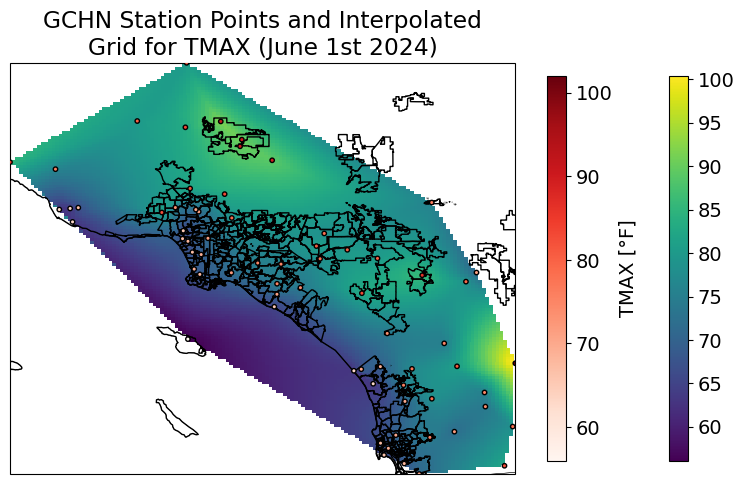

In [29]:
# set up figure and projection
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=proj))

# add title, axis labels, and coastlines
ax.coastlines()
ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='k')
ax.set_title(
    'GCHN Station Points and Interpolated\nGrid for TMAX (June 1st 2024)')

# add neighborhood/city boundaries
polys_neigh = polys_neigh.to_crs(proj)
ax.add_geometries(polys_neigh["geometry"],
                  crs=proj,
                  edgecolor='k',
                  facecolor='none')

# add rasterized GCHN daily image for TMIN/TMAX
gchn_img = ax.pcolormesh(maxtemps_xr.longitude,
                         maxtemps_xr.latitude,
                         CtoF(maxtemps_xr.temperature.values),
                         transform=to_proj)
fig.colorbar(gchn_img, shrink=0.5, pad=0.035)

# add GCHN station points with TMAX values
cs2 = ax.scatter(max_temps_daily.lon,
                 max_temps_daily.lat,
                 c=CtoF(max_temps_daily.value),
                 s=10,
                 transform=proj,
                 cmap='Reds',
                 edgecolor='k',
                 zorder=20)
cb = fig.colorbar(cs2, shrink=0.5)
cb.set_label('TMAX [°F]')

# zoom into southern CA
ax.set_extent([np.nanmin(max_temps_daily.lon),
               np.nanmax(max_temps_daily.lon),
               np.nanmin(max_temps_daily.lat),
               np.nanmax(max_temps_daily.lat)])

### Correlation between Zillow home prices and monthly min/max temperatures in southern California during summer 2024

Spearman correlation coef b/t monthly TMIN/TMAX and Zillow home prices
TMIN_jun_mean for ALL cities:
ρ=-0.13, p-val=0.10247
TMIN_jul_mean for ALL cities:
ρ=-0.34, p-val=1e-05
TMIN_aug_mean for ALL cities:
ρ=-0.15, p-val=0.06779
TMAX_jun_mean for ALL cities:
ρ=-0.28, p-val=0.00023
TMAX_jul_mean for ALL cities:
ρ=-0.38, p-val=0.0
TMAX_aug_mean for ALL cities:
ρ=-0.38, p-val=0.0


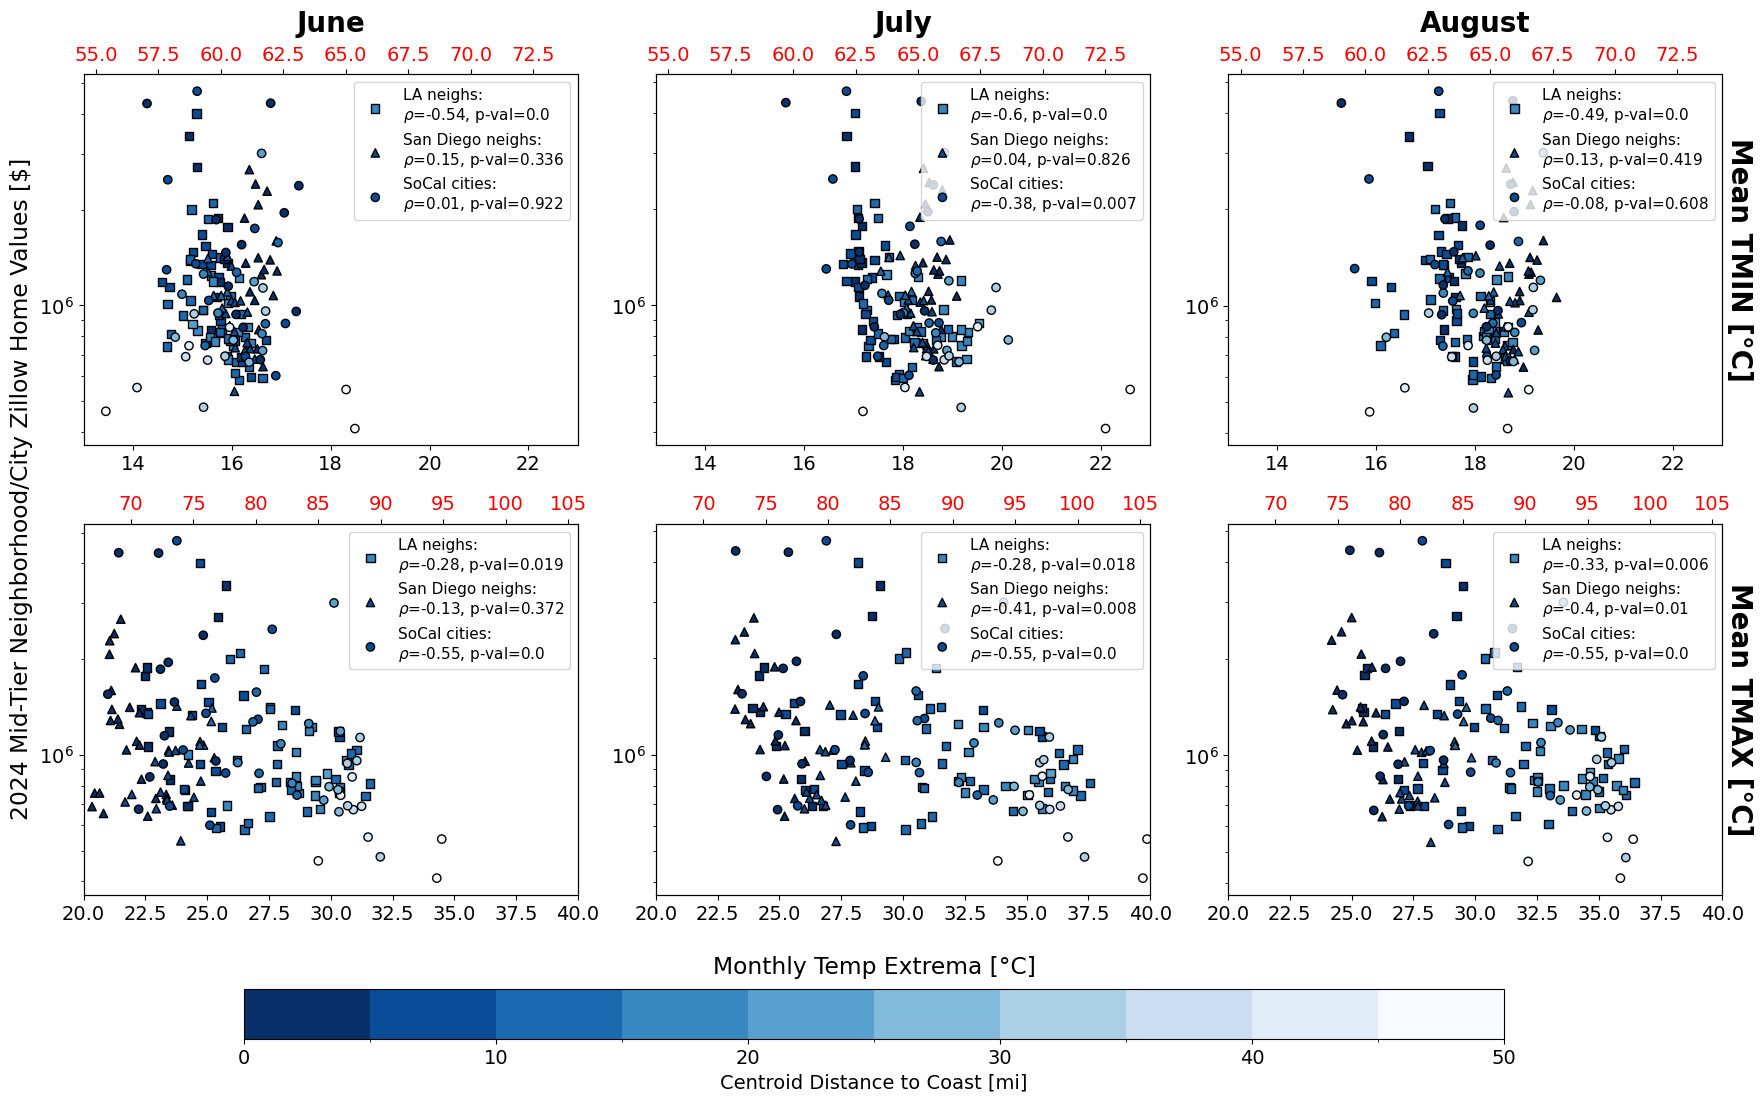

In [31]:
# create 2x3 grid of plots
fig, axes_main = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.supxlabel('Monthly Temp Extrema [°C]');
fig.supylabel('2024 Mid-Tier Neighborhood/City Zillow Home Values [$]')

# flatten the axes array
axes = axes_main.flatten()

# initialize iterator variables for each subplot
mons = ['2024-06-30',	'2024-07-31',	'2024-08-31',
        '2024-06-30',	'2024-07-31',	'2024-08-31']
temp_mon = ['TMIN_jun_mean',	'TMIN_jul_mean',	'TMIN_aug_mean',
            'TMAX_jun_mean',	'TMAX_jul_mean',	'TMAX_aug_mean']
print('Spearman correlation coef b/t monthly TMIN/TMAX and Zillow home prices')
for j in range(6):
    # plot each monthly TMIN/TMAX VS Zillow prices
    axes[j].set_yscale('log')
    axes[j].scatter(la.loc[:, temp_mon[j]], la.loc[:, mons[j]],
                    c=la.loc[:, 'coast_dist_mi'], cmap='Blues_r',
                    norm=BoundaryNorm(range(0, 55, 5), 256),
                    marker='s', edgecolors='k',
                    label='LA neighs:\n' + r'$\rho$=' + \
                    str(np.round(spearmanr(la.loc[:, temp_mon[j]],
                                           la.loc[:, mons[j]],
                                           nan_policy='omit')[0], 2)) +\
                        r', p-val=' + str(np.round(spearmanr(
                            la.loc[:, temp_mon[j]], la.loc[:, mons[j]], nan_policy='omit')[1], 3)))
    axes[j].scatter(sd.loc[:, temp_mon[j]], sd.loc[:, mons[j]],
                    c=sd.loc[:, 'coast_dist_mi'], cmap='Blues_r',
                    norm=BoundaryNorm(range(0, 55, 5), 256),
                    marker='^', edgecolors='k',
                    label='San Diego neighs:\n' + r'$\rho$=' + \
                    str(np.round(spearmanr(sd.loc[:, temp_mon[j]],
                                           sd.loc[:, mons[j]], nan_policy='omit')[0], 2)) +\
                        r', p-val=' + str(np.round(spearmanr(
                            sd.loc[:, temp_mon[j]], sd.loc[:, mons[j]], nan_policy='omit')[1], 3)))
    im=axes[j].scatter(socal.loc[:, temp_mon[j]], socal.loc[:, mons[j]],
                    c=socal.loc[:, 'coast_dist_mi'], cmap='Blues_r',
                    norm=BoundaryNorm(range(0, 55, 5), 256),
                    edgecolors='k',# marker='x',
                    label='SoCal cities:\n' + r'$\rho$=' + \
                    str(np.round(spearmanr(socal.loc[:, temp_mon[j]],
                                           socal.loc[:, mons[j]], nan_policy='omit')[0], 2)) +\
                        r', p-val=' + str(np.round(spearmanr(
                            socal.loc[:, temp_mon[j]], socal.loc[:, mons[j]], nan_policy='omit')[1], 3)))
    # print Spearman correlation coefficient for all Zillow prices and TMIN/TMAX
    print(temp_mon[j] + ' for ALL cities:\n' + r'ρ=' + \
                    str(np.round(spearmanr(
                        pd.concat([sd, la, socal]).loc[:, temp_mon[j]],
                        pd.concat([sd, la, socal]).loc[:, mons[j]], nan_policy='omit')[0], 2)) +\
                        r', p-val=' + str(np.round(spearmanr(
                            pd.concat([sd, la, socal]).loc[:, temp_mon[j]],
                            pd.concat([sd, la, socal]).loc[:, mons[j]],
                            nan_policy='omit')[1], 5)))
    # create bold labels to better indicate row and column structure
    if j==0:
      axes[j].set_title('June', weight='bold', fontsize=20, pad=10)
    if j==1:
      axes[j].set_title('July', weight='bold', fontsize=20, pad=10)
    if j==2:
      axes[j].set_title('August', weight='bold', fontsize=20, pad=10)
    if j==2:
      axes[j].set_ylabel('Mean TMIN [°C]', weight='bold', fontsize=20,
                         rotation=270, labelpad=22)
      axes[j].yaxis.set_label_position("right")
    if j==5:
      axes[j].set_ylabel('Mean TMAX [°C]', weight='bold', fontsize=20,
                         rotation=270, labelpad=22)
      axes[j].yaxis.set_label_position("right")
    axes[j].legend(fontsize=11)
    # create twin x-axis for temps in Fahr.
    if np.any(j == np.array([0, 1, 2])):
      ax_twin = axes[j].twiny()
      ax_twin.scatter(CtoF(np.arange(13,24)), [1e6]*len(np.arange(13,24)),
                      color='none')
      #ax_twin.set_ylabel('Customer Satisfaction Score', color='orange')
      ax_twin.tick_params(axis='x', labelcolor='r')
      axes[j].set_xlim(13, 23)
    if np.any(j == np.array([3, 4, 5])):
      ax_twin = axes[j].twiny()
      ax_twin.scatter(CtoF(np.arange(20,41)), [1e6]*len(np.arange(20,41)),
                      color='none')
      #ax_twin.set_ylabel('Customer Satisfaction Score', color='orange')
      ax_twin.tick_params(axis='x', labelcolor='r')
      axes[j].set_xlim(20, 40)

# additional subplot and colorbar modifications
fig.subplots_adjust(bottom=0.1)
cbar_ax = fig.add_axes([0.15, -0.05, 0.7, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Centroid Distance to Coast [mi]')
fig.tight_layout()

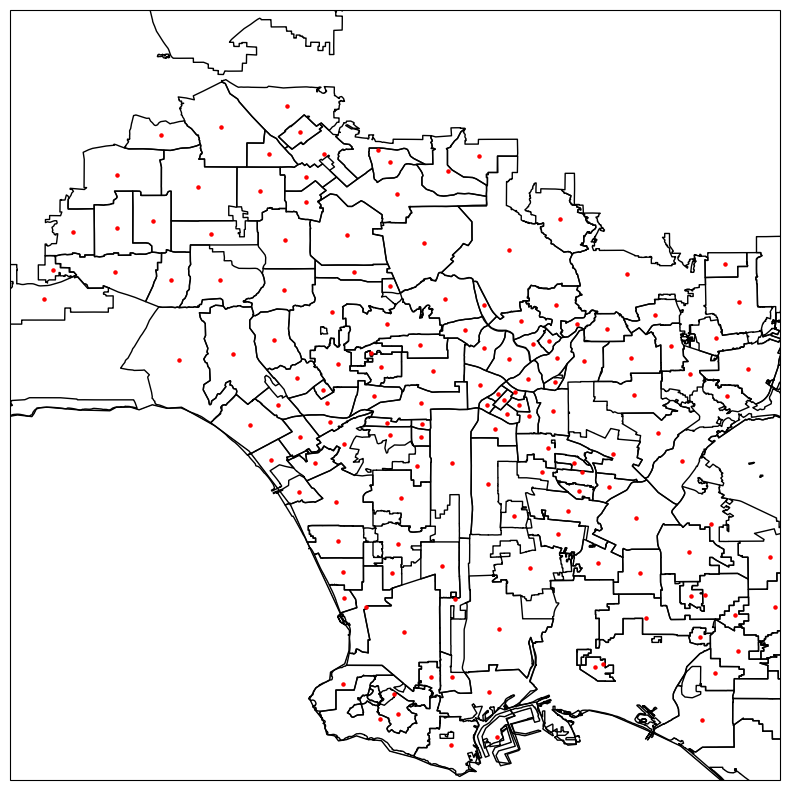

In [ ]:
## Define the main projection for the map
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection=proj))

## add title, axis labels, and coastlines
ax.coastlines()
ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='k')

## ALL SD/LA neigh polygons
#la_polys = la_polys.to_crs(proj)
#los_ang = polys[polys.CITY == 'Los Angeles'].to_crs(proj)#San Diego']
ax.add_geometries(polys_neigh["geometry"].to_crs(proj),#los_ang['geometry'],
                  crs=proj,  # Changed from polys.crs
                  edgecolor='k',
                  facecolor='none',  # Changed from color=None to be explicit
                  #alpha=0.5,
                  zorder=20)

## add neigh/city polygon centroids
polys_neigh.geometry.centroid.to_crs(ccrs.PlateCarree()).plot(
    ax=ax, markersize=5, color="r", zorder=30)

#ax.set_extent([-118+0.5,-117+0.5,32.5,33.3])
ax.set_extent([-118.7,-118,33.7,34.4])

## Initial working map for all data, except GOES18.....
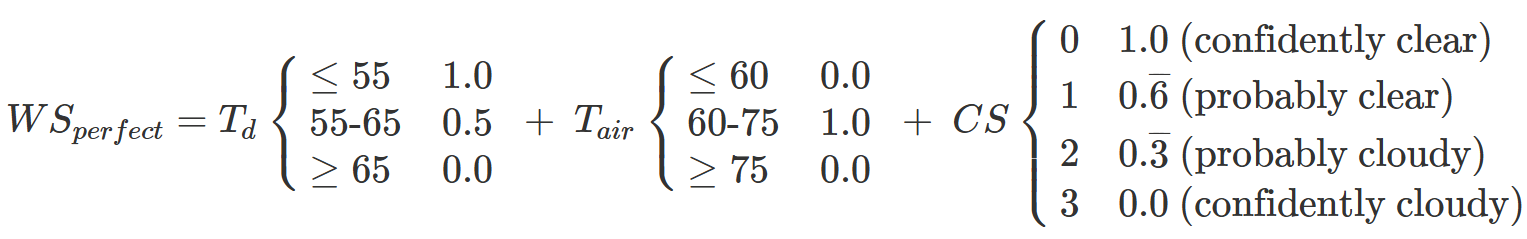

##### Open GOES-18 RHUM & Cloud Cover datasets in xarray

In [ ]:
################# RHUM #################
## get filenames for every downloaded file (and no missing data inclusions)
filenames = []
for month in [6]:
    for day in np.arange(1, 31):
        for hour in np.arange(0, 24, 3):
            try:
                filenames.append(
                    goes_nearesttime(datetime(2024, month, day, hour),
                                     satellite=18,
                                     domain='C',
                                     product='ABI-L2-LVMPC', # moisture data
                                     #product='ABI-L2-LSTC', # land surf Temp
                                     #product='ABI-L2-ACMC', # cloud mask
                                     #return_as='xarray')#,
                                     download=False).path[0]
                )
            except FileNotFoundError:
                print(f'No file for {month}-{day} - {hour} Z')
for month in [7, 8]:
    for day in np.arange(1, 32):
        for hour in np.arange(0, 24, 3):
            try:
                filenames.append(
                    goes_nearesttime(datetime(2024, month, day, hour),
                                     satellite=18,
                                     domain='C',
                                     product='ABI-L2-LVMPC', # moisture data
                                     #product='ABI-L2-LSTC', # land surf Temp
                                     #product='ABI-L2-ACMC', # cloud mask
                                     #return_as='xarray')#,
                                     download=False).path[0]
                )
            except FileNotFoundError:
                print(f'No file for {month}-{day} - {hour} Z')

## create list of complete path names
prefix = dir + 'socal_weather_data/moisture/'
suffix = '/*.nc'
final_paths_list = list(map(
    lambda item: prefix + os.path.dirname(item) +suffix,
    filenames))
## get actual filenames in each directory
rhum_paths = []
for i in range(len(final_paths_list)):
    rhum_paths.append(glob.glob(final_paths_list[i])[0])

## open ~730 3 hr RHUM data for Jun-Aug, 2024
rhum = xr.open_mfdataset(rhum_paths, engine='h5netcdf', combine='nested',
                         #compat='override',
                         concat_dim=['t'])
rhum

In [ ]:
################# Cloud Cover #################
## get filenames for every downloaded file (and no missing data inclusions)
filenames = []
for month in [6]:
    for day in np.arange(1, 31):
        for hour in np.arange(0, 24, 3):
            try:
                filenames.append(
                    goes_nearesttime(datetime(2024, month, day, hour),
                                     satellite=18,
                                     domain='C',
                                     #product='ABI-L2-LVMPC', # moisture data
                                     product='ABI-L2-ACMC', # cloud mask
                                     #return_as='xarray')#,
                                     download=False).path[0]
                )
            except FileNotFoundError:
                print(f'No file for {month}-{day} - {hour} Z')
for month in [7, 8]:
    for day in np.arange(1, 32):
        for hour in np.arange(0, 24, 3):
            try:
                filenames.append(
                    goes_nearesttime(datetime(2024, month, day, hour),
                                     satellite=18,
                                     domain='C',
                                     #product='ABI-L2-LVMPC', # moisture data
                                     product='ABI-L2-ACMC', # cloud mask
                                     #return_as='xarray')#,
                                     download=False).path[0]
                )
            except FileNotFoundError:
                print(f'No file for {month}-{day} - {hour} Z')

## create list of complete path names
prefix = dir + 'socal_weather_data/cloudmask/'
suffix = '/*.nc'
final_paths_list = list(map(
    lambda item: prefix + os.path.dirname(item) + suffix,
    filenames))
## get actual filenames in each directory
cloud_paths = []
for i in range(len(final_paths_list)):
    if not glob.glob(final_paths_list[i]):
        continue
    else:
        cloud_paths.append(glob.glob(final_paths_list[i])[0])

## open ~730 3 hr Cloud Cover data for Jun-Aug, 2024
cloud = xr.open_mfdataset(cloud_paths, engine='h5netcdf', combine='nested',
                         #compat='override',
                         concat_dim=['t'], parallel=False)
cloud

<xarray.Dataset> Size: 44GB
Dimensions:                                                     (t: 732,
                                                                 y: 1500,
                                                                 x: 2500,
                                                                 number_of_time_bounds: 2,
                                                                 number_of_image_bounds: 2,
                                                                 RTM_BT_comparison_bands: 2,
                                                                 number_of_focal_planes_used: 2,
                                                                 number_of_LZA_bounds: 2,
                                                                 number_of_SZA_bounds: 2)
Coordinates:
  * t                                                           (t) datetime64[ns] 6kB ...
  * y                                                           (y) float32 6kB ...
  * x                                                           (x) float32 10kB ...
    y_image                                                     float32 4B 0....
    x_image                                                     float32 4B 0.0
    retrieval_local_zenith_angle                                float32 4B 90.0
    quantitative_local_zenith_angle                             float32 4B 70.0
    retrieval_solar_zenith_angle                                float32 4B 180.0
    RTM_BT_comparison_wavelengths                               (RTM_BT_comparison_bands) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    RTM_BT_comparison_band_ids                                  (RTM_BT_comparison_bands) int8 2B dask.array<chunksize=(2,), meta=np.ndarray>
Dimensions without coordinates: number_of_time_bounds, number_of_image_bounds,
                                RTM_BT_comparison_bands,
                                number_of_focal_planes_used,
                                number_of_LZA_bounds, number_of_SZA_bounds
Data variables: (12/41)
    BCM                                                         (t, y, x) float32 11GB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    ACM                                                         (t, y, x) float32 11GB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    Cloud_Probabilities                                         (t, y, x) float32 11GB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    DQF                                                         (t, y, x) float32 11GB dask.array<chunksize=(1, 250, 250), meta=np.ndarray>
    time_bounds                                                 (t, number_of_time_bounds) datetime64[ns] 12kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    goes_imager_projection                                      (t) int32 3kB ...
    ...                                                          ...
    quantitative_local_zenith_angle_bounds                      (t, number_of_LZA_bounds) float32 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    twilight_solar_zenith_angle                                 (t) float32 3kB ...
    retrieval_solar_zenith_angle_bounds                         (t, number_of_SZA_bounds) float32 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    twilight_solar_zenith_angle_bounds                          (t, number_of_SZA_bounds) float32 6kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    percent_uncorrectable_GRB_errors                            (t) float32 3kB ...
    percent_uncorrectable_L0_errors                             (t) float32 3kB ...
Attributes: (12/29)
    naming_authority:          gov.nesdis.noaa
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    institution:               DOC/NOAA/NESDIS > U.S. Department of Commerce,...
    project:                   GOES
    ...            

In [ ]:
test = cloud.sel().isel(t=0).ACM
test = test.to_dataframe()
test = test.reset_index()
test_gdf = gpd.GeoDataFrame(test, geometry=gpd.points_from_xy(
    test.longitude, test.latitude), crs=to_proj.proj4_init)
test_gdf.plot()

KeyboardInterrupt: 

In [ ]:
# surface level pressure
rhum_crs, rhum_x, rhum_y = abi_crs(rhum.isel(t=0,pressure=3), "LVM")
# cloud coverage as 4 categories
cloud_crs, cloud_x, cloud_y = abi_crs(cloud.isel(t=0), "ACM")

##### Download GOES-18 RHUM & Cloud Cover raster data for June-Aug 2024

In [ ]:
# download 3 hr data for the 2024 summer months (JJA) into Google Drive
# no June 31, so use separate for loop
for month in [6]:
    for day in [1]:#np.arange(1, 31):
        for hour in np.arange(0, 24, 3):
            try:
                g = goes_nearesttime(datetime(2024, month, day, hour),
                                     satellite=18,
                                     domain='C',
                                     # moisture data
                                     #product='ABI-L2-LVMPC',
                                     product='ABI-L2-ACMC', # cloud mask
                                     #return_as='xarray')#,
                                     download=True,
                                     save_dir = dir + 'socal_weather_data/cloudmask/',
                                     overwrite=False)
            except FileNotFoundError:
                print(f'No file for {day} - {hour} Z')

📦 Finished downloading [1] files to [/content/drive/My Drive/socal_weather_data/cloudmask/noaa-goes18/ABI-L2-ACMC].
📚 Finished reading [1] files into xarray.Dataset.
📦 Finished downloading [1] files to [/content/drive/My Drive/socal_weather_data/cloudmask/noaa-goes18/ABI-L2-ACMC].
📚 Finished reading [1] files into xarray.Dataset.
📦 Finished downloading [1] files to [/content/drive/My Drive/socal_weather_data/cloudmask/noaa-goes18/ABI-L2-ACMC].
📚 Finished reading [1] files into xarray.Dataset.
📦 Finished downloading [1] files to [/content/drive/My Drive/socal_weather_data/cloudmask/noaa-goes18/ABI-L2-ACMC].
📚 Finished reading [1] files into xarray.Dataset.
📦 Finished downloading [1] files to [/content/drive/My Drive/socal_weather_data/cloudmask/noaa-goes18/ABI-L2-ACMC].
📚 Finished reading [1] files into xarray.Dataset.
📦 Finished downloading [1] files to [/content/drive/My Drive/socal_weather_data/cloudmask/noaa-goes18/ABI-L2-ACMC].
📚 Finished reading [1] files into xarray.Dataset.
📦 Fi

In [ ]:
# download 3 hr data for the 2024 summer months (JJA) into Google Drive
# no June 31, so use separate for loop
for month in [6]:
    for day in np.arange(1, 31):
        for hour in np.arange(0, 24, 3):
            try:
                g = goes_nearesttime(datetime(2024, month, day, hour),
                                     satellite=18,
                                     domain='C',
                                     product='ABI-L2-LVMPC', # moisture data
                                     #product='ABI-L2-ACMC', # cloud mask
                                     #return_as='xarray')#,
                                     download=True,
                                     save_dir = dir + 'socal_weather_data/moisture/',
                                     overwrite=False)
            except FileNotFoundError:
                print(f'No file for {day} - {hour} Z')
for month in [7, 8]:
    for day in np.arange(1, 32):
        for hour in np.arange(0, 24, 3):
            try:
                g = goes_nearesttime(datetime(2024, month, day, hour),
                                     satellite=18,
                                     domain='C',
                                     product='ABI-L2-LVMPC', # moisture data
                                     #product='ABI-L2-ACMC', # cloud mask
                                     #return_as='xarray')#,
                                     download=True,
                                     save_dir = dir + 'socal_weather_data/moisture/',
                                     overwrite=False)
            except FileNotFoundError:
                print(f'No file for {day} - {hour} Z')